# Fake Job Detection with Machine Learning   
------------- 
**Author: Himal Aryal**

As a part of my Fontys University of Applied Sciences open program project, I aim to develop a machine learning system to detect fake job postings. The primary goal is to utilize various machine learning models such as Logistic Regression, Random Forest Classifier, Support Vector Machine Classifier, and K-Nearest Neighbors (KNN) to classify job postings as either legitimate or fake. We will use the Employment Scam Aegean Dataset (EMSCAD) from Kaggle to train and test our models.

EMSCAD records were manually annotated and classified into two categories. More specifically, the dataset contains 17,014 non-fradulent and 866 fraudulent job ads.

## Loading Dataset

The dataset includes 17 different types of information (features) for each job posting. These features can be categorized into textual descriptions, numerical data, and binary indicators. Of particular interest to us is the "fraudulent" column, which helps us distinguish between real (0) and fake (1) job postings.

In [114]:
import pandas as pd

#Loading the dataset
df=pd.read_csv('data/fake_job_postings.csv')

#Displaying the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head(5))

First few rows of the dataset:
   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                               

In [115]:
#Checking data types of each column
print("Data types of each column:")
print(df.dtypes)

#Display the shape of the DataFrame
print("Shape of the DataFrame:", df.shape)



Data types of each column:
job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object
Shape of the DataFrame: (17880, 18)


## Research Questions
Before we delve into the data, it’s important to outline what i aim to discover. This dataset offers a wealth of potential insights, and we have identified five main questions for our initial analysis:

- Which locations or departments see more fake job postings?

- Are there specific words or phrases in job descriptions that often appear in fake job postings?

- Which industries are most affected by fake job postings?

- Do fake job postings typically lack a company logo?

- Do certain employement types, experience levels, or educational requirements appear more frequently in fake job postings?




### Dealing with Missing Data

It's common to encounter missing values in datasets, and our dataset is no different. Upon initial inspection, I've visualized the distribution of these missing values across different columns.


In [116]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'
#this 

#calculate the proportion of missing values in each column
missing_percentage = df.isnull().mean() * 100

#create a DataFrame for plotting
missing_df = pd.DataFrame({'Columns': missing_percentage.index, 'Proportion of Missing Values (%)': missing_percentage.values})

#plotting with plotly
fig = px.bar(missing_df, x='Columns', y='Proportion of Missing Values (%)',
             title='Proportion of Missing Values in Each Column',
             labels={'Columns': 'Columns', 'Proportion of Missing Values (%)': 'Proportion of Missing Values (%)'},
             text=missing_df['Proportion of Missing Values (%)'].round(2).astype(str) + '%')

#adjust x-axis labels angle for better readability
fig.update_xaxes(tickangle=-45)

fig.show()

fig.write_image("images/missing_values.png")

### Handling Missing Data
i found that the columns for "department" and "salary_range" have a significant number of missing values. As a result, I've chosen to remove these columns from our analysis. While this decision may lead to losing insights into fraudulent activities within specific departments or salary ranges, it allows us to focus on more reliable data from other variables without significantly reducing our dataset.

In [117]:

#all string values to lowercase
df = df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

# Drop columns with high missing values
columns_to_drop = ['salary_range', 'department']
df = df.drop(columns_to_drop, axis=1)



After removing missing data from the dataset, the next thing I'm looking at is how many job postings are fraudulent versus non-fradulent. This helps me understand if there's an imbalance between real and fake postings. By seeing this balance, I can prepare better to build a machine learning system that can accurately spot fake job ads. This step is crucial to ensure our system can handle both types of postings effectively.

### Distribution of fraudulent job postings

In [118]:
import plotly.express as px

# calculates the number of occurrences of each unique value in the fraudulent column of the df
job_type_counts = df['fraudulent'].value_counts().reset_index()
#renames the columns of the df for clarity
job_type_counts.columns = ['Fraudulent', 'Count']

#map fraudulent labels for better readability
job_type_counts['Fraudulent'] = job_type_counts['Fraudulent'].map({0: 'Non-Fradulent', 1: 'Fraudulent'})

#create a bar plot using plotly
fig = px.bar(job_type_counts, x='Fraudulent', y='Count', color='Fraudulent',
             labels={'Fraudulent': 'Job Type', 'Count': 'Count'},
             title='Distribution of Fraudulent Job Postings',
             text='Count')

#ppdate layout for better presentation
fig.update_layout(yaxis_title='Count', xaxis={'categoryorder': 'total descending'}, width=600)

#show plot
fig.show()

fig.write_image("images/job_posting.png")

Addressing Class Imbalance

In our dataset, there are many more Non-fradulent job postings than fraudulent ones. This imbalance could affect our analysis. I'll investigate strategies to handle this issue effectively.




# Exploratory Data Analysis (EDA)
EDA is a crucial step in data science where we dive deep into our dataset. Its main goals are to understand how our data is organized, find any mistakes or unusual points, and discover patterns or trends. During this stage, we clean our data by fixing or removing missing or wrong information that could affect our predictions

First of all, visualizing the correlation between numerical columns in a df using a heatmap helps us understand how different variables relate to each other. The heatmap shows which variables move together positive correlation or move in opposite directions negative correlation. This helps in identifying patterns and relationships within the data, which is crucial for making informed decisions in data analysis and modeling

In [119]:
import numpy as np
import plotly.express as px


#selects only the numerical columns from df
#ensures that only numerical variables are included in further analysis
numerical_data = df.select_dtypes(include=[np.number])

#computes the correlation matrix for the numerical data numericaldata
correlation_matrix = numerical_data.corr()

#uses plotly px to create a heatmap imshow from the correlation matrix correlation_matrix
fig = px.imshow(correlation_matrix, color_continuous_scale='electric', #specifies the color scheme for the heatmap
                labels=dict(x="Features", y="Features", color="Correlation"),
                title="Correlation Matrix of Numerical Variables")

#iterates through each cell in the correlation matrix to add annotations correlation values to the heatmap
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        #adds text annotations with formatted correlation values
        fig.add_annotation(x=i, y=j, text=f"{correlation_matrix.iloc[i, j]:.2f}",
                           showarrow=False, font=dict(color='white', size=12),
                           xshift=10, yshift=10)

#updating the layout
fig.update_layout(width=600, height=500)


fig.show()


fig.write_image("images/numerical_correlation.png")

The heatmap shows that most of the variables I looked at don't have strong relationships with each other—they are lightly colored, indicating weak correlation. However, there's a noticeable exception: job postings that display a company logo tend to also include questions for applicants. This connection is shown by a positive correlation value of 0.23 between these two variables.


## Now, let's explore a different charts that show fraudulent and non-fradulent job postings based on different aspects:

First, before we continue for further analysis, I added a countryCode column to identify job locations by country, and then mapped these codes to full country names countryFull for clarity and analysis based on geographical data.

In [120]:
#adding a new column countryCode based on the location column
df['country_code'] = df['location'].str.split(',').str[0].str.strip()

#mapping the country codes to their full names
country_mapping = {
    'us': 'United States', 'gb': 'United Kingdom', 'gr': 'Greece',
    'nz': 'New Zealand', 'de': 'Germany', 'be': 'Belgium',
    'ca': 'Canada', 'in': 'India', 'au': 'Australia', 'nl': 'Netherlands',
    'fr': 'France', 'eg': 'Egypt', 'se': 'Sweden', 'ph': 'Philippines',
    'ae': 'United Arab Emirates', 'sg': 'Singapore', 'es': 'Spain',
    'ie': 'Ireland', 'dk': 'Denmark'
}

#ading a new column countryfull based on the countryCode column
df['country_full'] = df['country_code'].map(country_mapping)
# df

After I created two separate dataframes for visualizing fraudulent and non-fraudulent job postings. This separation allows us to analyze and visualize these two categories independently.

In [121]:
##creates a new df: df_non_fraudulent and df_fradulant containing rows from the original df where the fraudulent column has a value of 0 and 1
df_non_fraudulent = df[df['fraudulent'] == 0]
df_fraudulent = df[df['fraudulent'] == 1]

### Proportion and Ratio of Fraudulent Job Postings by Country

In [122]:
import pandas as pd
import plotly.express as px

#concatenate df_non_fraudulent and df_fraudulent back together
df_filtered = pd.concat([df_non_fraudulent, df_fraudulent])

#group by country_full and calculate the mean of the fraudulent column
#this gives the proportion of fraudulent job postings
country_fraud_proportions = df_filtered.groupby('country_full')['fraudulent'].mean().reset_index()
country_fraud_proportions.columns = ['country_full', 'proportion']

#sort the data by the proportion of fraudulent job postings in descending order
country_fraud_proportions = country_fraud_proportions.sort_values(by='proportion', ascending=False)

#calculate the ratio of fraudulent to non-fraudulent job postings
country_fraud_proportions['non_fraudulent'] = 1 - country_fraud_proportions['proportion']
country_fraud_proportions['fraudulent_ratio'] = country_fraud_proportions['proportion'] / country_fraud_proportions['non_fraudulent']

#create plotly bar plot
fig = px.bar(
    country_fraud_proportions, 
    x='country_full', 
    y='proportion',
    labels={'country_full': 'Country', 'proportion': 'Proportion of Fraudulent Job Postings'},
    title='Proportion and Ratio of Fraudulent Job Postings by Country',
    width=800
)

#adding ratio as text on each bar for additional insight
fig.update_traces(texttemplate='%{y:.2f} <br> Ratio: %{customdata:.2f}', 
                  textposition='outside', 
                  customdata=country_fraud_proportions['fraudulent_ratio'])

fig.show()

fig.write_image("images/bycountry_.png")

What do we observe?

From the data, I notice that some countries have more fraudulent job postings. Australia and the United States particularly stand out, with about 18.7% and 6.9% of their job ads possibly being fake, respectively. This means a large portion of job listings from these countries might not be genuine. In contrast, countries like Singapore, Sweden, Netherlands, and others don't have any reported fraudulent postings in this dataset.

Looking at the ratio of fraudulent to non-fraudulent job postings gives us more clarity. Australia and the United States also show higher ratios compared to countries with no fraudulent postings. This two-sided view reveals significant differences in job posting honesty globally. It highlights the importance for job seekers to be careful, especially when considering opportunities from countries where fake job activities are more common.

### Visualization of Fraudulent Job Postings by Industry: Count and Ratio

In [123]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#filters df to include only rows where fraudulent is 1 (indicating fraudulent job postings)
industry_counts = df_filtered[df_filtered['fraudulent'] == 1]['industry'].value_counts() #counts the occurrences of each industry

#calculate total counts of job postings by industry in the filtered dataset
total_industry_counts = df_filtered['industry'].value_counts()

# Calculate ratio of fraudulent job postings to total job postings by industry
industry_ratio = industry_counts / total_industry_counts

#sorts the industry counts series in descending order based on the count of fraudulent job postings
industry_counts_sorted = industry_counts.sort_values(ascending=False)
#sorts the industry ratio series in descending order based on the ratio of fraudulent job postings
industry_ratio_sorted = industry_ratio.sort_values(ascending=False)

#Initializes a fig with 1 row and 2 columns for subplots, each with specified titles
fig = make_subplots(rows=1, cols=2, subplot_titles=("Number of Fake Job Postings by Industry", 
                                                    "Ratio of Fake Job Postings by Industry"))

#adding a plot go.Bar to the first subplot row=1, col=1 with industries on the x-axis 
#and counts of fraudulent job postings on the y-axis
fig.add_trace(go.Bar(x=industry_counts_sorted.index, y=industry_counts_sorted.values,
                     name="Fake Job Postings Count", 
                     marker=dict(color='blue')), 
              row=1, col=1)

#adding a bar plot to the second subplot row=1, col=2 with industries on the x-axis and ratios of fraudulent job postings on the y-axis
fig.add_trace(go.Bar(x=industry_ratio_sorted.index, y=industry_ratio_sorted.values,
                     name="Ratio of Fake Job Postings", 
                     marker=dict(color='red')), 
              row=1, col=2)

#update layout
fig.update_layout(title_text="Fake Job Postings Analysis by Industry", width=1200, height=600)
fig.update_xaxes(tickangle=-45)

fig.show()

fig.write_image("images/by_industry.png")

What do you observe ?

I observe that the Oil & Energy industry has the most fake job postings (109), followed by Accounting (57), and Hospital & Health Care (51). Marketing and Advertising and Financial Services also have notable counts. Some industries, like Ranching and Medical Devices, have very few fake job postings (1 each).

Regarding the ratio of fake job postings, Ranching has the highest ratio with all job postings being fake, followed by Military (0.5), and Animation (0.4). The Oil & Energy industry also has a high ratio of about 0.38, and Accounting is at 0.36. This indicates that certain industries, especially Oil & Energy and Accounting, have both high counts and high ratios of fake job postings.

### Visualization of Fraudulent Job Postings by Required Experience: Count and Ratio

In [124]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# counts the occurrences of each required experience level among fraudulent job postings
experience_counts = df_filtered[df_filtered['fraudulent'] == 1]['required_experience'].value_counts()

# calculate the total counts of each required experience level in the entire filtered dataset
total_experience_counts = df_filtered['required_experience'].value_counts()

# perform element-wise division of the required experience counts series by the total experience counts series
experience_ratio = experience_counts / total_experience_counts

# Sorting the experience ratio Series in descending order
experience_ratio_sorted = experience_ratio.sort_values(ascending=False)

# Creates subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Number of Fake Job Postings by Required Experience", 
                                                    "Ratio of Fake Job Postings by Required Experience"))

# Adding bar plot for number of fake job postings by required experience
fig.add_trace(go.Bar(x=experience_counts.index, y=experience_counts.values,
                     name="Fake Job Postings Count", 
                     marker=dict(color='blue')), 
              row=1, col=1)

# adding bar plot for ratio of fake job postings by required experience
fig.add_trace(go.Bar(x=experience_ratio_sorted.index, y=experience_ratio_sorted.values,
                     name="Ratio of Fake Job Postings", 
                     marker=dict(color='red')), 
              row=1, col=2)

# update layout
fig.update_layout(title_text="Fake Job Postings Analysis", width=1200, height=600)
fig.update_xaxes(tickangle=-45)

fig.show()

fig.write_image("images/by_required_experience.png")

what do you observe ?

high counts vs high ratios: 

Entry-level and mid-senior level job postings have high counts of fake postings, but the ratio % of fake postings is not as high compared to executive-level roles. This means while there are many fake postings at these levels, they are not as likely to be fake when compared to their total numbers.

Executive-Level Roles: 

Even though there are fewer executive-level fake postings compared to entry-level or mid-senior roles, they have a higher percentage of fraud. This suggests that job seekers should be cautious when applying for high-level positions online.

Not Applicable Category: 

Job postings where experience level is not specified also show a moderate risk of being fake, indicating that vague or general postings should be approached with caution.

### Visualization of Fraudulent Job Postings by Required Education: Count and Ratio

In [125]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd

#group by required education and count the occurrences for fraudulent job postings
education_fraud_counts = df_filtered[df_filtered['fraudulent'] == 1]['required_education'].value_counts().reset_index()
education_fraud_counts.columns = ['required_education', 'count']  # Rename columns for clarity

# sort the df by count in descending order
education_fraud_counts_sorted = education_fraud_counts.sort_values(by='count', ascending=False)

# Calculate the total counts of each required education level in the entire dataset
total_education_counts = df_filtered['required_education'].value_counts().reset_index()
total_education_counts.columns = ['required_education', 'total_count']

# merge the fraudulent counts with the total counts to calculate the ratio
education_counts_merged = pd.merge(education_fraud_counts, total_education_counts, on='required_education')

# calculate the ratio of fake job postings to total job postings
education_counts_merged['ratio'] = education_counts_merged['count'] / education_counts_merged['total_count']

# sort the DataFrame by ratio in descending order
education_ratio_sorted = education_counts_merged.sort_values(by='ratio', ascending=False)

# Creating subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Number of Fake Job Postings by Required Education", 
                                                    "Ratio of Fake Job Postings by Required Education"))

# adding bar plot for number of fake job postings by required education
fig.add_trace(go.Bar(x=education_fraud_counts_sorted['required_education'], y=education_fraud_counts_sorted['count'],
                     name="Fake Job Postings Count", 
                     marker=dict(color='blue'), 
                     text=education_fraud_counts_sorted['count'], textposition='outside'), 
              row=1, col=1)

#adding bar plot for ratio of fake job postings by required education
fig.add_trace(go.Bar(x=education_ratio_sorted['required_education'], y=education_ratio_sorted['ratio'],
                     name="Ratio of Fake Job Postings", 
                     marker=dict(color='red'), 
                     text=education_ratio_sorted['ratio'].round(2), textposition='outside'), 
              row=1, col=2)

# layout update
fig.update_layout(title_text="Fake Job Postings Analysis by Required Education", width=1200, height=600)
fig.update_xaxes(tickangle=-45)

fig.show()



fig.write_image("images/by_required_eductaion.png")

When looking at job postings to see if they're real or fake, I found that some types of jobs are more likely to be fake than others based on the education they ask for. Jobs that only need "some high school coursework" have the most fake postings, meaning there's a high chance they're not real jobs. On the other hand, jobs that require a "doctorate" have the fewest fake postings, so they're more likely to be genuine. Jobs asking for certifications or a master's degree have a medium risk of being fake, so it's important to be cautious with these too. Understanding these differences helps us better spot fake job postings and make smarter choices when applying for jobs.

### Visualization of Fraudulent Job Postings by Function: Count and Ratio

In [126]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd

#group the filtered data by function and count the occurrences
function_counts = df_filtered['function'].value_counts().reset_index()
function_counts.columns = ['function', 'count']

#group the filtered fraudulent data by function and count the occurrences
function_fraudulent_counts = df_filtered[df_filtered['fraudulent'] == 1]['function'].value_counts().reset_index()
function_fraudulent_counts.columns = ['function', 'fraudulent_count']

# Merge counts and fraudulent counts
function_counts = pd.merge(function_counts, function_fraudulent_counts, on='function', how='left')

# Calculate the ratio of fraudulent job postings by function
function_counts['fraudulent_ratio'] = function_counts['fraudulent_count'] / function_counts['count']

# Sort by count in descending order
function_counts_sorted = function_counts.sort_values(by='count', ascending=False)

# Create subplots with two columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("Number of Fake Job Postings by Function", 
                                                    "Ratio of Fake Job Postings by Function"))

# adding bar plot for number of fake job postings by function
fig.add_trace(go.Bar(x=function_counts_sorted['function'], y=function_counts_sorted['count'],
                     name="Fake Job Postings Count", marker_color='blue'), 
              row=1, col=1)

# adding bar plot for ratio of fake job postings by function
fig.add_trace(go.Bar(x=function_counts_sorted['function'], y=function_counts_sorted['fraudulent_ratio'],
                     name="Ratio of Fake Job Postings", marker_color='red'), 
              row=1, col=2)

fig.update_layout(title_text="Fake Job Postings Analysis by Function", width=1200, height=600)
fig.update_xaxes(tickangle=-45)

fig.show()

fig.write_image("images/by_function.png")


what do you obeserve ?

I found that jobs like Administrative and Accounting/Auditing have a higher percentage of fake postings compared to others. For example, nearly 19% of job ads in Administrative roles turned out to be fake. On the other hand, job categories such as Information Technology and Marketing have fewer fake job postings, meaning they are generally safer. Some job categories, like Writing/Editing and Production, didn't have enough data to tell how many of their job ads were fake. This helps me see which job areas are more risky for fake job ads, so I can be more careful when looking for jobs in those fields.

### Visualization of Fraudulent Job Postings by employement type: Count and Ratio

In [127]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd

#group the filtered data by employment type and count the occurrences
employment_type_counts = df_filtered['employment_type'].value_counts().reset_index()
employment_type_counts.columns = ['employment_type', 'count']

#count fraudulent job postings by employment type in the filtered dataset
fraudulent_counts = df_filtered[df_filtered['fraudulent'] == 1]['employment_type'].value_counts().reset_index()
fraudulent_counts.columns = ['employment_type', 'fraudulent_count']

# Merge counts and fraudulent counts
employment_type_counts = pd.merge(employment_type_counts, fraudulent_counts, on='employment_type', how='left')

# Calculate the ratio of fraudulent job postings by employment type
employment_type_counts['fraudulent_ratio'] = employment_type_counts['fraudulent_count'] / employment_type_counts['count']

# Sort by count in descending order
employment_type_counts_sorted = employment_type_counts.sort_values(by='count', ascending=False)

# Create subplots with two columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("Number of Fake Job Postings by Employment Type", 
                                                    "Ratio of Fake Job Postings by Employment Type"))

# Adding bar plot for number of fake job postings by employment type
fig.add_trace(go.Bar(x=employment_type_counts_sorted['employment_type'], y=employment_type_counts_sorted['count'],
                     name="Fake Job Postings Count", marker_color='blue'), 
              row=1, col=1)

# Adding bar plot for ratio of fake job postings by employment type
fig.add_trace(go.Bar(x=employment_type_counts_sorted['employment_type'], y=employment_type_counts_sorted['fraudulent_ratio'],
                     name="Ratio of Fake Job Postings", marker_color='red'), 
              row=1, col=2)

fig.update_layout(title_text="Fake Job Postings Analysis by Employment Type", width=1200, height=600)
fig.update_xaxes(tickangle=-45)

fig.show()

fig.write_image("images/by_employement_type.png")


what do you observe?

The graph shows that full-time positions are the most common, with around 11,500 postings, and they have a low fraudulent ratio of 0.042. Part-time roles, despite being fewer at around 800 postings, have a higher fraudulent ratio of 0.093, indicating a greater risk of fraud. Temporary roles, with only 241 postings, show the lowest fraudulent ratio at 0.008. Other types, totaling around 200 postings, have varying fraudulent ratios from 0.028 to 0.066. This suggests that while full-time jobs are numerous and less likely to be fraudulent, part-time roles need closer scrutiny due to their higher fraud risk.

### Number of Fraudulent and Non-Fraudulent Job Postings by Company Logo

In [128]:
import plotly.express as px

#group the data by company logo and fraudulent, then counts the number of occurrences in each group
#this pivot the grouped data so that fraudulent values become columns, the fill value=0 argument replaces any missing values with 0
logo_fraud_counts = df_filtered.groupby(['has_company_logo', 'fraudulent']).size().unstack(fill_value=0).reset_index()
#resets the index to turn the grouped data back into a regular df
logo_fraud_counts.columns = ['has_company_logo', 'Real', 'Fake']

#convert the has_company_logo column to categorical values for better readability
logo_fraud_counts['has_company_logo'] = logo_fraud_counts['has_company_logo'].map({0: 'No', 1: 'Yes'})

#create a bar plot using plotly 
fig = px.bar(
    #converts the df from wide format to long format
    #keeps has_company_logo as an identifier column
    logo_fraud_counts.melt(id_vars='has_company_logo', var_name='Type', value_name='Count'),
    x='has_company_logo', 
    y='Count', 
    color='Type',
    barmode='group',
    labels={'has_company_logo': 'Has Company Logo', 'Count': 'Number of Job Postings'},
    title='Number of Fake and Real Job Postings by Company Logo'
)

fig.show()

fig.write_image("images/by_company_logo.png")

what do you observe?

The graph illustrates job postings categorized by whether they include a company logo (Yes or No) and distinguishes between real and fake postings. It's evident that postings with a company logo (Yes) are more prevalent overall. However, both categories feature instances of fake postings. (Yes) shows a higher number of real postings but still includes some fakes, whereas (No) has fewer postings overall but a higher ratio of fake postings compared to real ones.

### Number of Fraudulent and Non-Fraudulent Job Postings by has_questions

In [129]:
import plotly.express as px

#group the data by has_questions and fraudulent, then count occurrences in each group
questions_fraud_counts = df_filtered.groupby(['has_questions', 'fraudulent']).size().unstack(fill_value=0).reset_index()
questions_fraud_counts.columns = ['has_questions', 'Real', 'Fake']

#convert has_questions column to categorical values for better readability
questions_fraud_counts['has_questions'] = questions_fraud_counts['has_questions'].map({0: 'No', 1: 'Yes'})

#create a bar plot 
fig = px.bar(
    # convert the dataframe from wide format to long format
    questions_fraud_counts.melt(id_vars='has_questions', var_name='Type', value_name='Count'),
    x='has_questions', 
    y='Count', 
    color='Type',
    barmode='group',
    labels={'has_questions': 'Has Questions', 'Count': 'Number of Job Postings'},
    title='Number of Fake and Real Job Postings by Questions Requirement'
)

fig.show()

fig.write_image("images/by_has_question.png")

what do you observe ?

The bar plot shows that job postings requiring questions (has_questions = Yes) have more total postings compared to those that do not require questions (has_questions = No). Despite this, there are fewer fake postings relative to real ones where questions are required, indicating that requiring questions might help in filtering out fraudulent job postings.

### Keywords Extraction: Comparing Company Profiles in Fraudulent vs Non-Fraudulent Job Postings

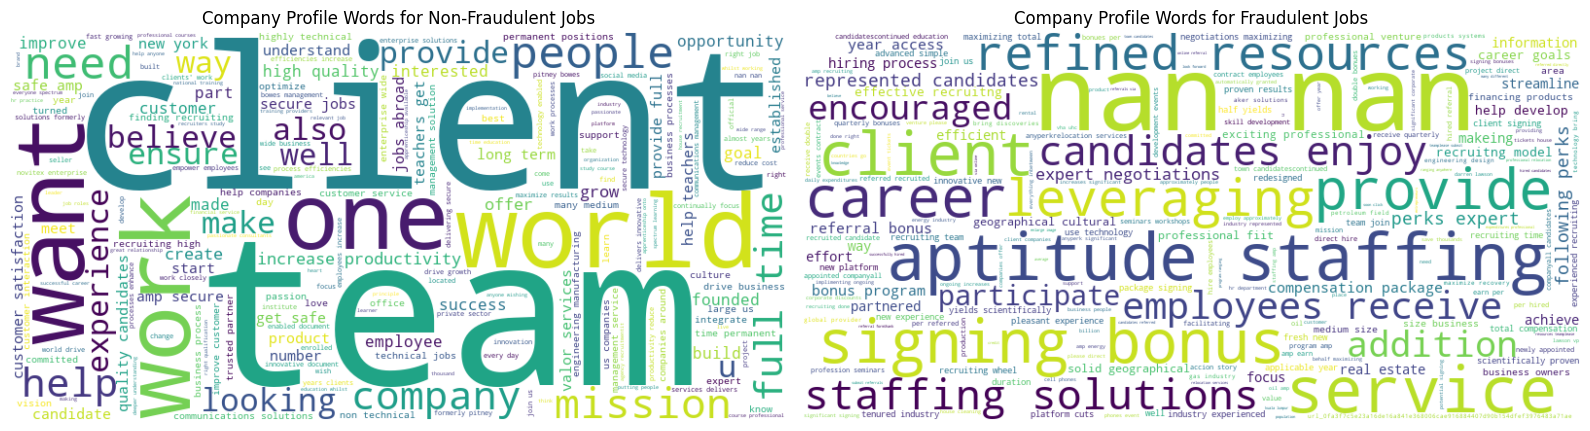

In [130]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

#converts the company profile descriptions from the non-fraudulent postings into a single string
#NaN values are handled by converting them to strings
company_profile_non_fraudulent_text = ' '.join(df_non_fraudulent['company_profile'].astype(str))
company_profile_fraudulent_text = ' '.join(df_fraudulent['company_profile'].astype(str))

#create WordCloud objects
wordcloud_non_fraudulent = WordCloud(stopwords=stopwords.words("english"),
                                    background_color='white',
                                    width=800, height=400).generate(company_profile_non_fraudulent_text)

wordcloud_fraudulent = WordCloud(stopwords=stopwords.words("english"),
                                 background_color='white',
                                 width=800, height=400).generate(company_profile_fraudulent_text)

#plotting both WordClouds side by side 
plt.figure(figsize=(16, 8))

# plot for non-fraudulent 
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_non_fraudulent, interpolation='bilinear')
plt.title("Company Profile Words for Non-Fraudulent Jobs")
plt.axis('off')

# little gap between the subplots
plt.subplots_adjust(wspace=0.3)

#Plot for fraudulent 
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_fraudulent, interpolation='bilinear')
plt.title("Company Profile Words for Fraudulent Jobs")
plt.axis('off')

plt.tight_layout()
plt.show()




what do we observe?

The word cloud analysis shows that non-fraudulent job postings emphasize teamwork, client service, specific job roles, and locations. On the other hand, fraudulent postings focus on perks like signing bonuses, specific industries, and technology to attract applicants. This comparison helps spot genuine job offers based on stability and roles, contrasting them with potentially deceptive ones that emphasize perks and industry specifics.

### Keywords Extraction: Comparing Description in Fraudulent vs Non-Fraudulent Job Postings

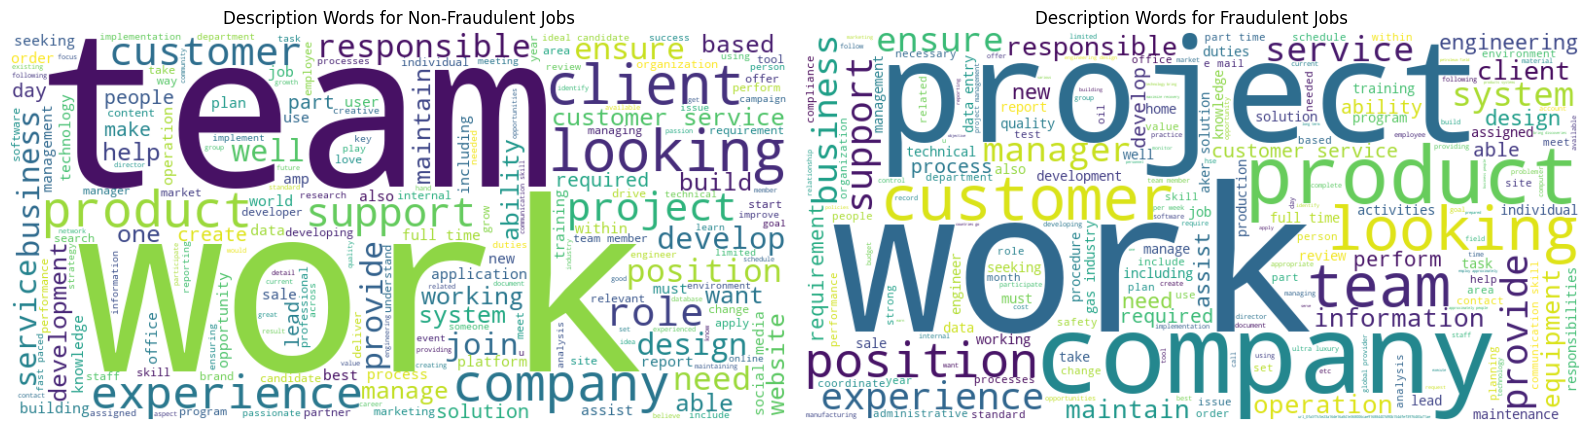

In [131]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

#convert the descriptions from non-fraudulent postings into a single string
# NaN values are handled by converting them to strings
description_non_fraudulent_text = ' '.join(df_non_fraudulent['description'].astype(str))
description_fraudulent_text = ' '.join(df_fraudulent['description'].astype(str))

#create WordCloud objects
wordcloud_non_fraudulent_desc = WordCloud(stopwords=stopwords.words("english"),
                                         background_color='white',
                                         width=800, height=400).generate(description_non_fraudulent_text)

wordcloud_fraudulent_desc = WordCloud(stopwords=stopwords.words("english"),
                                      background_color='white',
                                      width=800, height=400).generate(description_fraudulent_text)

#plotting both WordClouds side by side 
plt.figure(figsize=(16, 8))

#plot for non fraudulent descriptions
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_non_fraudulent_desc, interpolation='bilinear')
plt.title("Description Words for Non-Fraudulent Jobs")
plt.axis('off')

#little gap between the subplots
plt.subplots_adjust(wspace=0.3)

#plot for fraudulent descriptions
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_fraudulent_desc, interpolation='bilinear')
plt.title("Description Words for Fraudulent Jobs")
plt.axis('off')

plt.tight_layout()
plt.show()




What do you observe?

Looking at the visualization, I see that non-fraudulent job postings emphasize words like team, experience, business, and management, suggesting a focus on genuine career growth and professional environments. In contrast, fraudulent postings also highlight words like work and skills, possibly aiming to attract candidates with promises of employment, but lacking depth in professional development or real job opportunities.

### Keywords Extraction: Comparing requiremnts & benefits in Fraudulent vs Non-Fraudulent Job Postings

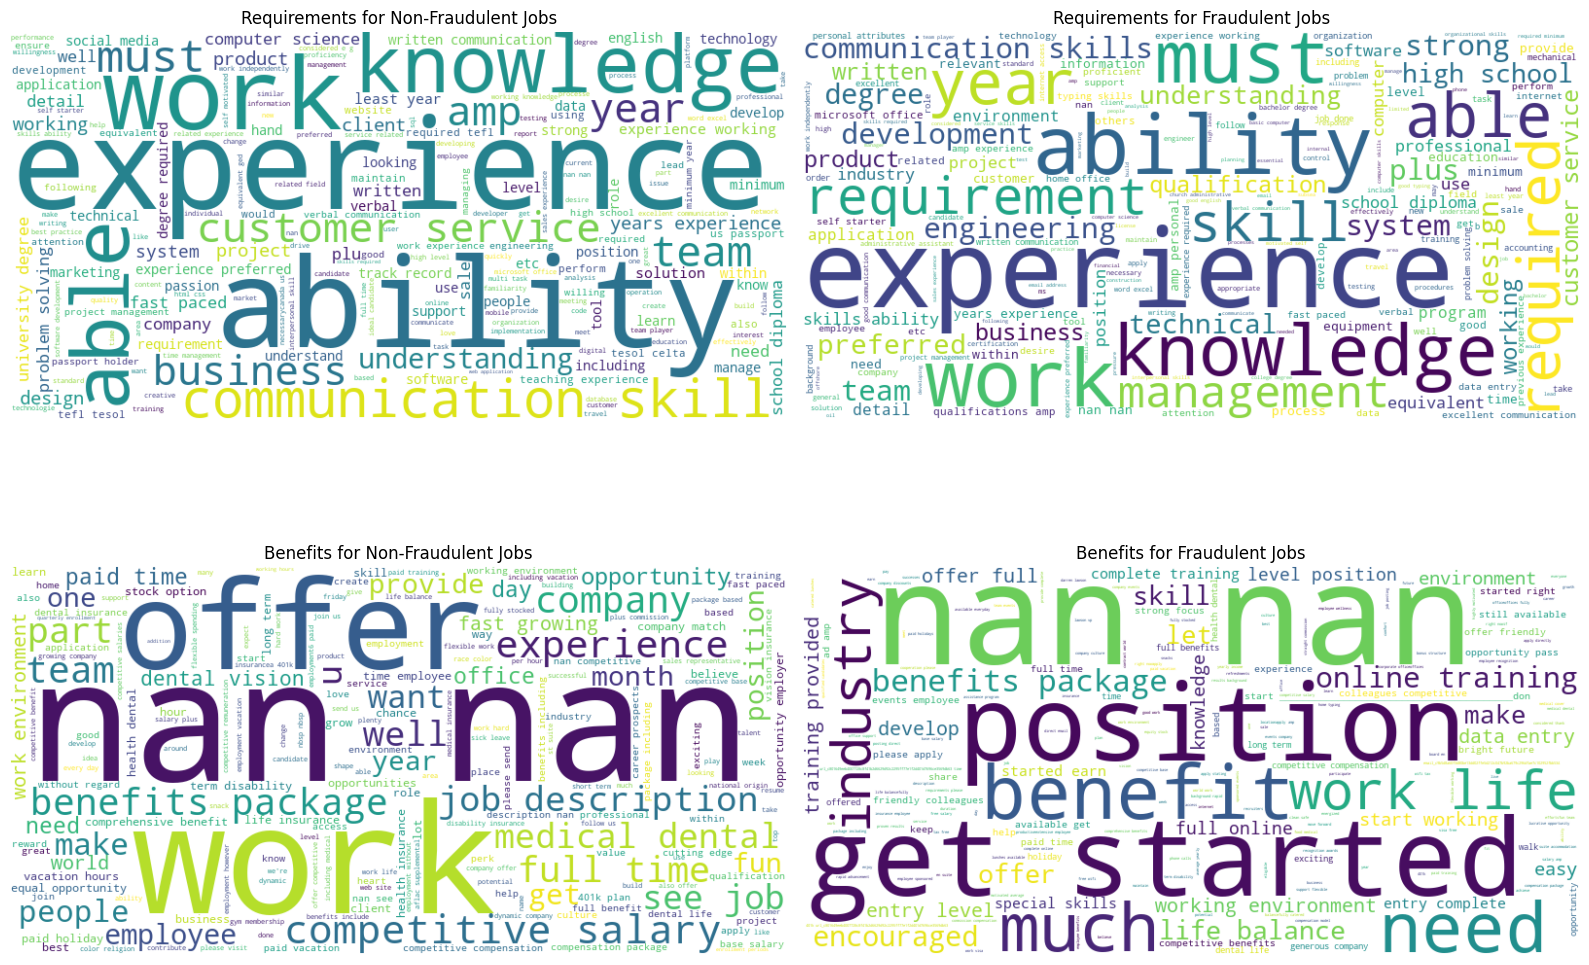

In [132]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

#convert the requirements and benefits from non-fraudulent postings into single strings
# NaN values are handled by converting them to strings
requirements_non_fraudulent_text = ' '.join(df_non_fraudulent['requirements'].astype(str))
requirements_fraudulent_text = ' '.join(df_fraudulent['requirements'].astype(str))

benefits_non_fraudulent_text = ' '.join(df_non_fraudulent['benefits'].astype(str))
benefits_fraudulent_text = ' '.join(df_fraudulent['benefits'].astype(str))

#create WordCloud objects for requirements
wordcloud_requirements_non_fraudulent = WordCloud(stopwords=stopwords.words("english"),
                                                 background_color='white',
                                                 width=800, height=400).generate(requirements_non_fraudulent_text)

wordcloud_requirements_fraudulent = WordCloud(stopwords=stopwords.words("english"),
                                              background_color='white',
                                              width=800, height=400).generate(requirements_fraudulent_text)

#create WordCloud objects for benefits
wordcloud_benefits_non_fraudulent = WordCloud(stopwords=stopwords.words("english"),
                                              background_color='white',
                                              width=800, height=400).generate(benefits_non_fraudulent_text)

wordcloud_benefits_fraudulent = WordCloud(stopwords=stopwords.words("english"),
                                          background_color='white',
                                          width=800, height=400).generate(benefits_fraudulent_text)

#plotting WordClouds for requirements and benefits side by side
plt.figure(figsize=(16, 12))

#plot for non-fraudulent requirements
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_requirements_non_fraudulent, interpolation='bilinear')
plt.title("Requirements for Non-Fraudulent Jobs")
plt.axis('off')

#plot for fraudulent requirements
plt.subplot(2, 2, 2)
plt.imshow(wordcloud_requirements_fraudulent, interpolation='bilinear')
plt.title("Requirements for Fraudulent Jobs")
plt.axis('off')

#plot for non-fraudulent benefits
plt.subplot(2, 2, 3)
plt.imshow(wordcloud_benefits_non_fraudulent, interpolation='bilinear')
plt.title("Benefits for Non-Fraudulent Jobs")
plt.axis('off')

#plot for fraudulent benefits
plt.subplot(2, 2, 4)
plt.imshow(wordcloud_benefits_fraudulent, interpolation='bilinear')
plt.title("Benefits for Fraudulent Jobs")
plt.axis('off')

plt.tight_layout()
plt.show()



Whast do you observe ?

- In terms of requirements:

Non-Fraudulent Jobs: The most frequent words include experience, skills, and specific job-related terms. This suggests that these job postings focus on clear qualifications and professional abilities needed for the role.

Fraudulent Jobs: On the other hand, common words are home, online, and terms implying easy qualifications. This indicates that these postings might be emphasizing remote work or flexible conditions without clearly defining necessary skills, potentially misleading job seekers.

- Regarding benefits:

Non-Fraudulent Jobs: Words such as healthcare, competitive, and opportunities appear frequently. This implies that these job postings emphasize genuine benefits like healthcare coverage, competitive salaries, and growth opportunities within the company.

Fraudulent Jobs: Words like earn, income, and phrases focusing on financial gain are prevalent. This suggests that these postings might promise easy earnings or financial incentives without detailing realistic benefits or career growth prospects.

## Fraudulent Job Postings by Industry

In [133]:
#we already have porportion and ratio which explain all , this is extra

#create a bar plot
fig = px.bar(
    df_fraudulent,  
    x="fraudulent",  
    y="industry",  
    color="industry",  #color bars by 'industry'
    pattern_shape="industry",  #use different patterns for each industry
    pattern_shape_sequence=[".", "x", "+", "-", "x", "|"],  #specify pattern shapes
    labels={'fraudulent': 'Fraudulent', 'industry': 'Industry'},  # labeling axes
    title='Fraudulent Job Postings by Industry' 
)


fig.show()


fig.write_image("images/by_industry_extra.png")


What do you observe?

I observe that different industries have varying numbers of fraudulent job postings. For instance, industries like oil & energy have a higher number of fraudulent postings, specifically 109 cases. This suggests that job seekers should be cautious when considering opportunities in such sectors. On the other hand, industries like accounting, hospital & health care, marketing and advertising also show significant counts of fraudulent postings, indicating a widespread issue across various professional domains. Industries with lower counts, such as consumer goods or online media, might still have fraudulent postings but at a much lower frequency compared to the higher-risk sectors.

## Analysis of employment type, required experience, and required education columns for Fraudulent and Non-Fraudulent Job Postings by country:

### 3D Scatter Plot of Fraudulent Job Postings

In [134]:
# create a 3D scatter plot of fraudulent job postings
fig_3d_fraudulent_jobs = px.scatter_3d(
    df_fraudulent, 
    x="employment_type", 
    y="required_experience", 
    z="required_education", 
    color="employment_type", 
    size="fraudulent", 
    hover_name=df_fraudulent.index, 
    symbol="country_full",
    opacity=0.5,
    size_max=10,  # Maximum size of the markers
    color_discrete_map={"employment_type": "blue", "has_company_logo": "green", "has_questions": "red"}
    #maps specific attributes
)

fig_3d_fraudulent_jobs.update_layout(
    title='3D Scatter Plot of Fraudulent Job Postings',

)

fig_3d_fraudulent_jobs.show()


fig.write_image("images/by_3d_job_plot.png")


What do you observe here?

The horizontal line (x-axis) shows the type of job—whether it's full-time, part-time, or something else. The vertical line (y-axis) tells us how much experience is needed for each job, like if it's for beginners or more experienced people. The depth (z-axis) shows what education level is required, from no special education needed to advanced degrees.

Each point's color tells us the type of job it is, with different shades of blue meaning different categories. The size of each point shows how likely it is that the job posting might be fake. Bigger points mean there's a higher chance it's not a real job. The size of these points has been adjusted to make it easier to see the differences.

The points aren't completely solid; they're a bit see-through (opacity is set to 0.5), which helps us see where points overlap without losing sight of the overall picture. Plus, the colors on the points help us understand more about the jobs—blue for job types, green if the company logo is included, and red if there are specific questions in the job application.

Overall, this graph helps us see patterns in job postings and understand which types of jobs might have more fake postings, based on their type, experience level, and education requirements.

### 3D Scatter Plot of Non Fraudulent Job Postings

In [135]:
import plotly.express as px

#create a 3D scatter plot of non-fraudulent job postings
fig_non_fraudulent_3d = px.scatter_3d(
    df_non_fraudulent, 
    x="employment_type", 
    y="required_experience", 
    z="required_education", 
    color="employment_type", 
    size="fraudulent", 
    hover_name=df_non_fraudulent.index, 
    symbol="country_full",
    opacity=0.5,
    size_max=10,  # maximum size of the markers
    color_discrete_map={"employment_type": "blue", "has_company_logo": "green", "has_questions": "red"}
    #maps specific attributes
)


fig_non_fraudulent_3d.update_traces(marker=dict(size=2))
#size of 2 unit, aiming to improve visual clarity and maintain consistency with other plotted data

#layout update
fig_non_fraudulent_3d.update_layout(
    title='3D Scatter Plot of Non-Fraudulent Job Postings',

)


fig_non_fraudulent_3d.show()



fig.write_image("images/by_3d_non_fradulent.png")

What do you observe here?

This 3D scatter plot shows non-fraudulent job postings using different markers based on their employment type, required experience, and education level. Each dot represents a job listing, positioned according to these factors. The color of each dot tells us its employment type, like full-time or part-time jobs. The size of the dots shows how 'fraudulent' a job might be, but since these are genuine postings, the dots are small. It also uses symbols to show where each job is located. The plot helps us see how real job listings are spread out across these categories.

### Density Comparison of Job Postings: Fraudulent vs Non-Fraudulent based on Has_Questions

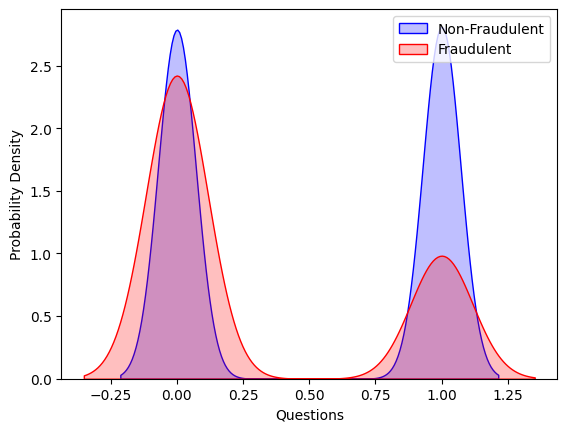

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

# KDE plot for non-fraudulent entries (fraudulent = 0)
sns.kdeplot(df_non_fraudulent['has_questions'], color='b', fill=True, legend=True,       #Note this is analysing from different aspects which 
            common_norm=True, common_grid=True, label='Non-Fraudulent')                  #focus on kde density comparison of job posting we can do
                                                                                         #same for rest also :This is one example.
# KDE plot for fraudulent entries (fraudulent = 1)
sns.kdeplot(df_fraudulent['has_questions'], color='r', fill=True, legend=True,
            common_norm=True, common_grid=True, label='Fraudulent')

plt.xlabel('Questions')
plt.ylabel('Probability Density')
plt.legend() 
plt.show()



What do you observe?

Non-fraudulent job postings generally have more questions (average of 0.50) compared to fraudulent postings (average of 0.29). There's also greater variability in the number of questions among non-fraudulent postings, suggesting they provide more detailed job information. Fraudulent postings, on the other hand, show less variability in question content, possibly indicating a more standardized approach. This difference suggests that the presence and variability of questions could help differentiate between genuine and fraudulent job ads.



### Character Count in Job Descriptions

In [137]:
import pandas as pd
import plotly.express as px

#converts each column to string type and concatenates them into one string per row using ' '.join()
df['combined_text'] = df.select_dtypes(include=['object']).apply(lambda x: ' '.join(x.astype(str)), axis=1)

#calculate the character count of the combined text
df['char_count'] = df['combined_text'].str.len()

# Calculate IQR for char count
Q1 = df['char_count'].quantile(0.25)
Q3 = df['char_count'].quantile(0.75)
IQR = Q3 - Q1
#IQR helps identify the spread and variability of character counts across the dataset
#determine the range of typical character counts

#calculates the lower and upper bounds for outliers based on the IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#creates a new df that excludes rows where char count is outside the determined outlier bounds
df_no_outliers = df[(df['char_count'] >= lower_bound) & (df['char_count'] <= upper_bound)]

#splits df_no_outliers into two separate df based on the fraudulent column: fraudulent jobs contains
# rows where fraudulent is 1 indicating fraudulent job postings, and non fraudulent jobs
# contains rows where fraudulent is 0 non-fraudulent job postings
fraudulent_jobs = df_no_outliers[df_no_outliers['fraudulent'] == 1]
non_fraudulent_jobs = df_no_outliers[df_no_outliers['fraudulent'] == 0]

#combines the char_count columns from fraudulent_jobs and non_fraudulent_jobs into
# a single df boxplot_df, it also adds a categorical column Job indicating whether the job posting is fraudulent or non-fraudulent
boxplot_df = pd.concat([
    fraudulent_jobs[['char_count']].assign(Job='Fraudulent'),
    non_fraudulent_jobs[['char_count']].assign(Job='Non-Fraudulent')
])

#create a box plot using px 
fig = px.box(
    boxplot_df, 
    x='Job', 
    y='char_count',
    title='Character Count in Job Descriptions',
    labels={'char_count': 'Character Count', 'Job': 'Job Type'},
    width=400,
    height=500
)

# Show the plot
fig.show()


fig.write_image("images/by_character_length.png")

This analysis focuses on comparing the length of job descriptions between real and fake job postings. I start by combining all text from job ads and calculating their character counts. After filtering out unusually short or long descriptions, I use a box plot to visualize the results:

Fraudulent Job Postings: These vary widely in length, ranging from very short descriptions (around 112 characters) to longer ones (up to 5,500 around characters). This variability suggests that fraudulent postings often lack detailed content.

Non-Fraudulent Job Postings: In contrast, genuine job ads tend to have more consistent character counts, generally falling between 1,300 to 5,400 characters. This indicates that real job postings typically provide more detailed information.

The box plot clearly illustrates that fraudulent job ads are generally shorter than non-fraudulent ones. This observation is crucial for developing strategies to identify and filter out fake job postings more effectively

In [138]:
df.head(1)

job_id             title          location  \
0       1  marketing intern  us, ny, new york   

                                     company_profile  \
0  we're food52, and we've created a groundbreaki...   

                                         description  \
0  food52, a fast-growing, james beard award-winn...   

                                        requirements benefits  telecommuting  \
0  experience with content management systems a m...      NaN              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           other          internship   

  required_education industry   function  fraudulent country_code  \
0                NaN      NaN  marketing           0           us   

    country_full                                      combined_text  \
0  United States  marketing intern us, ny, new york we're food52...   

   char_count  
0        2734

## Classification

Here, I started by making a copy of the original dataset to keep the original data safe. Then, I filled in any missing values with empty strings to avoid problems later. I combined the text from several columns (like title, company profile, description, requirements, and benefits) into a single column called text. This gave me a complete text description for each job posting. Next, I removed the now unnecessary columns to keep the dataset simple. I converted categorical columns (like telecommuting, has_company_logo, has_questions, employment_type, required_experience, required_education, industry, and function) into numbers using a label encoder, which is important for machine learning models. I also dropped any other irrelevant columns. Finally, I reordered the columns so that the text column is at the beginning, making it easier to read. The result is a clean and well-structured dataset, ready for machine learning tasks.

In [139]:
#create a copy of the original df
processed_df = df.copy()

# fill missing values with empty strings
processed_df.fillna(' ', inplace=True)

# concatenate textual columns into a single text column separated by spaces
processed_df['text'] = processed_df[['title', 'company_profile', 'description', 'requirements', 'benefits']].apply(lambda x: ' '.join(x), axis=1)

#drop unnecessary columns
processed_df.drop(['job_id', 'location', 'title', 'company_profile', 'description', 'requirements', 'benefits'], axis=1, inplace=True)

# encode categorical variables into numeric using label encoder
from sklearn.preprocessing import LabelEncoder
label_columns = ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
                 'required_experience', 'required_education', 'industry', 'function']
encoder = LabelEncoder()
for col in label_columns:
    processed_df[col] = encoder.fit_transform(processed_df[col])

# drop additional unnecessary columns
processed_df.drop(['combined_text', 'country_code', 'country_full'], axis=1, inplace=True)

# reorder columns putting text at the beginning
processed_columns = processed_df.columns.tolist()
processed_columns = processed_columns[-1:] + processed_columns[:-1]
final_df = processed_df[processed_columns]


final_df.head()


text  telecommuting  \
0  marketing intern we're food52, and we've creat...              0   
1  customer service - cloud video production 90 s...              0   
2  commissioning machinery assistant (cma) valor ...              0   
3  account executive - washington dc our passion ...              0   
4  bill review manager spotsource solutions llc i...              0   

   has_company_logo  has_questions  employment_type  required_experience  \
0                 1              0                3                    5   
1                 1              0                2                    7   
2                 1              0                0                    0   
3                 1              0                2                    6   
4                 1              1                2                    6   

   required_education  industry  function  fraudulent  char_count  
0                   0         0        23           0        2734  
1                   0        76         8           0        6235  
2                   0         0         0           0        2694  
3                   2        23        32           0        5567  
4                   2        52        17           0        4074

## Clean Text Function

I created a function called clean_text to preprocess text data. It removes numbers, converts text to lowercase, and eliminates unwanted characters like re:, dashes, underscores, URL, email addresses, and HTML tags. It also normalizes contractions and removes punctuation. After tokenizing the text, it filters out common stopwords and applies stemming to reduce words to their root forms. Finally, it joins the cleaned words back into a single string. I then apply this function to the text column in the final df dataframe to clean the text data.

In [140]:
import re
from nltk.stem import PorterStemmer

#define the clean_text function
def clean_text(text):
    if text is None:
        return ""
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # convert text to lowercase
    text = text.lower()
    
    # remove instances of 're:', dashes, and underscores
    text = re.sub(r're:', '', text)
    text = re.sub(r'[-_]', '', text)
    
    # remove URL
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # remove email addresses
    text = re.sub(r'\S*@\S*\s?', '', text)
    
    # remove text within square brackets
    text = re.sub(r'\[[^]]]*\]', '', text)
    
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # replace newlines with spaces
    text = re.sub(r'\n', ' ', text)
    
    # normalize contraction
    contractions = {
        r"\'ve": " have",
        r"can't": " cannot",
        r"n't": " not",
        r"I'm": "I am",
        r" m ": " am ",
        r"\'re": " are",
        r"\'d": " would",
        r"\'ll": " will"
    }
    for contraction, replacement in contractions.items():
        text = re.sub(contraction, replacement, text)
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # tokenize the text
    tokens = text.split()
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # stem the filtered tokens using PorterStemmer
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    
    # join stemmed tokens back into a single string
    processed_text = ' '.join(stemmed_tokens)
    
    return processed_text

# apply the clean text function to the df
final_df['text'] = final_df['text'].apply(clean_text)

print(final_df['text'].head())

0    market intern food weve creat groundbreak awar...
1    custom servic cloud video product second world...
2    commiss machineri assist cma valor servic prov...
3    account execut washington dc passion improv qu...
4    bill review manag spotsourc solut llc global h...
Name: text, dtype: object


I use TfidfVectorizer to convert the text data in the text column into a TF-IDF matrix with 100 features. I then create a df from this matrix, where each column represents a word's importance. Finally, I concatenate this TF-IDF DataFrame with the original processed_df df and drop unnecessary columns (char_count and text), resulting in a combined df ready for analysis.

In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer

# convert the text data into a TFIDF matrix
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(final_df['text'])

# create a df from the TF-IDF matrix
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

# concatenate the TF-IDF df with the original df
combined_df = pd.concat([tfidf_df, processed_df], axis=1)

# drop unnecessary columns
combined_df.drop(['char_count', 'text'], axis=1, inplace=True)


combined_df

abil   account      also       amp    applic      base   benefit  \
0      0.000000  0.000000  0.125712  0.111011  0.000000  0.000000  0.000000   
1      0.000000  0.042179  0.034068  0.060169  0.000000  0.062406  0.000000   
2      0.000000  0.000000  0.000000  0.093270  0.000000  0.000000  0.000000   
3      0.039323  0.569244  0.000000  0.000000  0.000000  0.000000  0.090179   
4      0.000000  0.109831  0.000000  0.000000  0.085903  0.000000  0.095696   
...         ...       ...       ...       ...       ...       ...       ...   
17875  0.039528  0.156058  0.084033  0.148412  0.000000  0.038482  0.000000   
17876  0.093718  0.740001  0.049809  0.131952  0.048232  0.091239  0.053731   
17877  0.000000  0.174456  0.000000  0.000000  0.000000  0.000000  0.000000   
17878  0.000000  0.000000  0.000000  0.205148  0.000000  0.106387  0.000000   
17879  0.000000  0.000000  0.094868  0.000000  0.137796  0.086889  0.000000   

           best     build      busi  ...      year  telecommuting  \
0      0.129447  0.000000  0.098407  ...  0.000000              0   
1      0.000000  0.000000  0.106674  ...  0.000000              0   
2      0.000000  0.000000  0.000000  ...  0.000000              0   
3      0.000000  0.118757  0.294477  ...  0.059091              0   
4      0.182695  0.000000  0.069443  ...  0.062706              0   
...         ...       ...       ...  ...       ...            ...   
17875  0.086529  0.119376  0.098671  ...  0.000000              0   
17876  0.000000  0.000000  0.000000  ...  0.070415              0   
17877  0.000000  0.000000  0.055152  ...  0.099602              0   
17878  0.000000  0.000000  0.000000  ...  0.000000              0   
17879  0.097687  0.000000  0.037131  ...  0.067058              0   

       has_company_logo  has_questions  employment_type  required_experience  \
0                     1              0                3                    5   
1                     1              0                2                    7   
2                     1              0                0                    0   
3                     1              0                2                    6   
4                     1              1                2                    6   
...                 ...            ...              ...                  ...   
17875                 1              1                2                    6   
17876                 1              1                2                    6   
17877                 0              0                2                    0   
17878                 0              1                1                    7   
17879                 1              1                2                    6   

       required_education  industry  function  fraudulent  
0                       0         0        23           0  
1                       0        76         8           0  
2                       0         0         0           0  
3                       2        23        32           0  
4                       2        52        17           0  
...                   ...       ...       ...         ...  
17875                   0        23        32           0  
17876                   2        62         1           0  
17877                   0         0         0           0  
17878                   7        49        10           0  
17879                   0        23        13           0  

[17880 rows x 109 columns]

## Train-Test Split

I divided the data into two parts: one for training and one for testing a machine learning model. First, I picked y as what I want to predict, taken from the last column of combined_df. Then, X became the features used to predict y, which includes all columns except the last one. Using train_test_split from sklearn, I split the data into four sets: X_train (features for training), y_train (predictions for training), X_test (features for testing), and y_test (predictions for testing). I set aside 30% of the data for testing to check how well the model predicts on new data. 

In [142]:
import pandas as pd
from sklearn.model_selection import train_test_split


#define target variable (dependent variable)
#line selects the last column
y = combined_df.iloc[:, -1]

#define feature variables (independent variables)
# selects all columns except the last one
X = combined_df.iloc[:, :-1]

# splitting into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (12516, 108)
Shape of y_train: (12516,)
Shape of X_test: (5364, 108)
Shape of y_test: (5364,)


## Model 1 : Logistic Regression

Logistic regression is a simple but effective algorithm used for binary classification, which means it helps us decide between two possible outcomes. Because of its simplicity and power, it's often the go-to choice for many classification tasks. So, I chose it as our first option for this task. Here are the results from our logistic regression model:

### Logistic Regression Before Balancing Data

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# create a pipeline with standard scaler and logistic regression
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# train the model
pipeline.fit(X_train, y_train)

# predict on test set
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Accuracy: 0.9584265473527218

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5093
           1       0.73      0.28      0.41       271

    accuracy                           0.96      5364
   macro avg       0.84      0.64      0.69      5364
weighted avg       0.95      0.96      0.95      5364


Confusion Matrix:
[[5064   29]
 [ 194   77]]


Here are the key insights:

Metrics:

Accuracy: 95.8%

Precision:

Non-Fraudulent (0): 96%
Fraudulent (1): 73%

Recall:

Non-Fraudulent (0): 99%
Fraudulent (1): 28%

F1-score:
Non-Fraudulent (0): 98%
Fraudulent (1): 41%

Confusion Matrix:

Shows true positives, true negatives, false positives, and false negatives.
Helps visualize model performance in terms of correct and incorrect predictions.

ROC Curve:

Visualizes the trade-off between true positive rate (sensitivity) and false positive rate (1 - specificity).
Area Under Curve (AUC) measures the model's ability to distinguish between classes.

Conclusion:

Logistic Regression initially achieved high accuracy but showed imbalanced class performance due to the dataset's skewed nature.

Due to fact, because there are many more Non-Fraudulent jobs 17,014 compared to fraudulent jobs 866, our model might not be as accurate as it seems.

To fix this, I can randomly reduce the number of Non-Fraudulent jobs in our dataset. This will create a balance where the number of fraudulent jobs is about the same as the number of Non-Fraudulent jobs. This will make our model's performance more accurate and meaningful.

## Data Balancing for Fraud Detection

In [144]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Data Balancing
# Separate the fraudulent and non-fraudulent cases
fraud_count = combined_df[combined_df['fraudulent'] == 1]
non_fraud_count = combined_df[combined_df['fraudulent'] == 0]

# Shuffle the legitimate cases and sample the same number as the fraudulent cases
legit_count_shuffled = non_fraud_count.sample(frac=1, random_state=42)
filtered_dataset = legit_count_shuffled.head(len(fraud_count))

# Combine the datasets and shuffle them
balanced_df = pd.concat([filtered_dataset, fraud_count], ignore_index=True).sample(frac=1, random_state=42)

# Separate features and target variable
X_balanced = balanced_df.drop('fraudulent', axis=1)
y_balanced = balanced_df['fraudulent']

print(f"Shape of reduced X: {X_balanced.shape}")
print(f"Shape of reduced Y: {y_balanced.shape}")

Shape of reduced X: (1732, 108)
Shape of reduced Y: (1732,)


###  Logistic Regression After Balancing Data

In [145]:
# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.30, random_state=42)

# Train logistic regression on the balanced dataset
logistic_reg = LogisticRegression(max_iter=1000)
logistic_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_balanced = logistic_reg.predict(X_test)

# Evaluate the model
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
print(f"Accuracy: {accuracy_balanced}\n")

print("Logistic Regression Classification Report After Balancing Data:")
print(classification_report(y_test, y_pred_balanced))

Accuracy: 0.8057692307692308

Logistic Regression Classification Report After Balancing Data:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       250
           1       0.82      0.81      0.81       270

    accuracy                           0.81       520
   macro avg       0.81      0.81      0.81       520
weighted avg       0.81      0.81      0.81       520



### Confusion Matrix & ROC Curve After Balancing Data For LogisticRegression

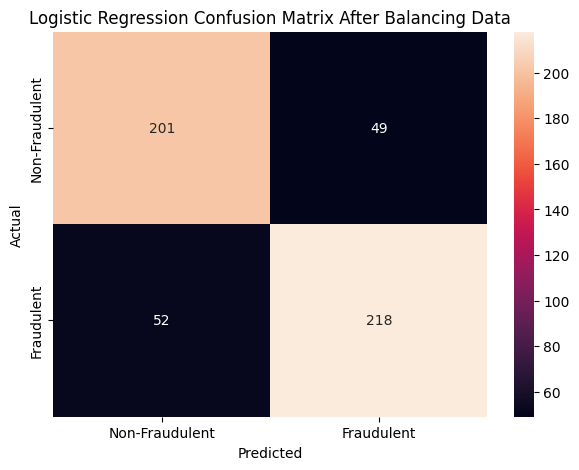

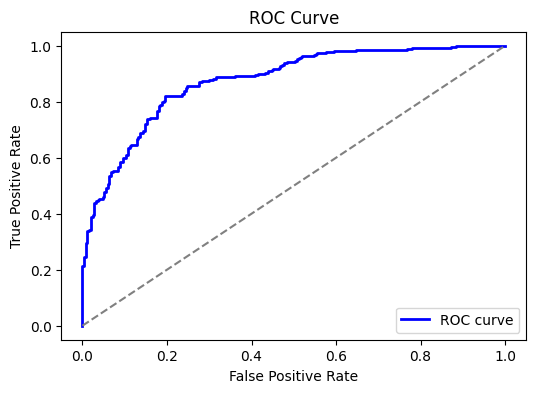

In [146]:
# Confusion Matrix
cm_balanced = confusion_matrix(y_test, y_pred_balanced)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_balanced, annot=True, fmt=".0f", xticklabels=['Non-Fraudulent', 'Fraudulent'], yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.title("Logistic Regression Confusion Matrix After Balancing Data")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, logistic_reg.predict_proba(X_test)[:, 1])

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

At this point hre it's important to remember that I balanced our dataset by removing many entries. This means we see a lower accuracy with logistic regression. Originally, using the unbalanced dataset, I achieved a high accuracy of 95%

## Model 2 : Random Forest Classifier 

Random Forest is a method that combines predictions from multiple decision trees to make a more accurate and reliable prediction. It's especially good at handling datasets that are imbalanced, making it an ideal choice for our needs.

### Random Forest Classifier with Entropy

Entropy is a measure of impurity or uncertainty in a set of data. In decision tree algorithms, particularly when building each individual tree in a Random Forest, entropy is used to decide how a tree should split at each node

Model Accuracy (Entropy): 0.8923076923076924
Classification Report (Entropy):
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       250
           1       0.91      0.88      0.89       270

    accuracy                           0.89       520
   macro avg       0.89      0.89      0.89       520
weighted avg       0.89      0.89      0.89       520



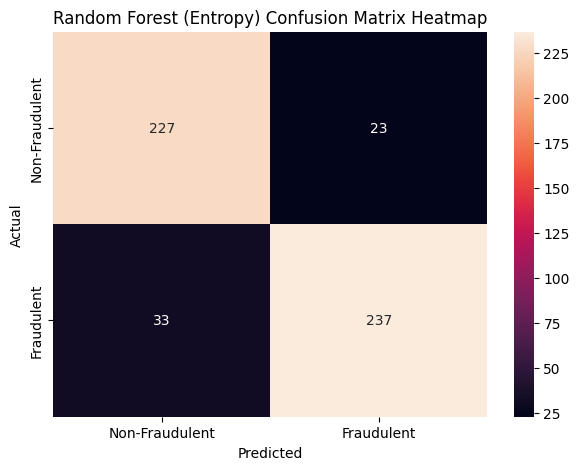

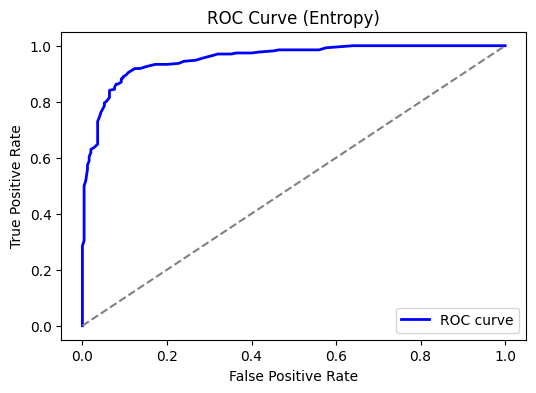

In [147]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Instantiate RandomForestClassifier with entropy criterion
rf_entropy = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=42, n_jobs=-1)

# Fit the model on training data
model_entropy = rf_entropy.fit(X_train, y_train)

# Predict on test data
y_pred_entropy = rf_entropy.predict(X_test)

# Calculate accuracy
accuracy_entropy = accuracy_score(y_test, y_pred_entropy)
print("Model Accuracy (Entropy):", accuracy_entropy)

# Print classification report
print("Classification Report (Entropy):")
print(classification_report(y_test, y_pred_entropy))

# Confusion matrix heatmap
cm_entropy = confusion_matrix(y_test, y_pred_entropy)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_entropy, annot=True, fmt=".0f", xticklabels=['Non-Fraudulent', 'Fraudulent'], yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.title("Random Forest (Entropy) Confusion Matrix Heatmap")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC curve
y_pred_prob_entropy = rf_entropy.predict_proba(X_test)[:, 1]
fpr_entropy, tpr_entropy, _ = roc_curve(y_test, y_pred_prob_entropy)

plt.figure(figsize=(6, 4))
plt.plot(fpr_entropy, tpr_entropy, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Entropy)')
plt.legend(loc='lower right')
plt.show()


### Random Forest Classifier with Gini Impurity

Gini impurity measures the degree or probability of a particular element being wrongly classified when it is randomly chosen. It is calculated by summing the probabilities of each item being chosen times the probability of a mistake in categorizing that item.

Model Accuracy (Gini): 0.9019230769230769
Classification Report (Gini):
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       250
           1       0.93      0.88      0.90       270

    accuracy                           0.90       520
   macro avg       0.90      0.90      0.90       520
weighted avg       0.90      0.90      0.90       520



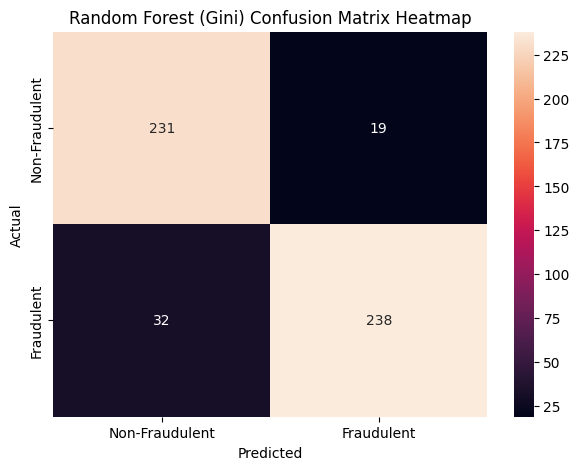

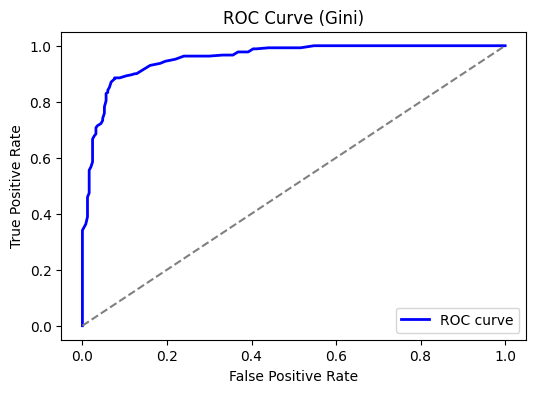

In [148]:
# Instantiate RandomForestClassifier with gini criterion
rf_gini = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=42, n_jobs=-1)

# Fit the model on training data
model_gini = rf_gini.fit(X_train, y_train)

# Predict on test data
y_pred_gini = rf_gini.predict(X_test)

# Calculate accuracy
accuracy_gini = accuracy_score(y_test, y_pred_gini)
print("Model Accuracy (Gini):", accuracy_gini)

# Print classification report
print("Classification Report (Gini):")
print(classification_report(y_test, y_pred_gini))

# Confusion matrix heatmap
cm_gini = confusion_matrix(y_test, y_pred_gini)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_gini, annot=True, fmt=".0f", xticklabels=['Non-Fraudulent', 'Fraudulent'], yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.title("Random Forest (Gini) Confusion Matrix Heatmap")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC curve
y_pred_prob_gini = rf_gini.predict_proba(X_test)[:, 1]
fpr_gini, tpr_gini, _ = roc_curve(y_test, y_pred_prob_gini)

plt.figure(figsize=(6, 4))
plt.plot(fpr_gini, tpr_gini, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Gini)')
plt.legend(loc='lower right')
plt.show()



In [149]:
#code for application
from sklearn.ensemble import RandomForestClassifier
import joblib

#instantiate RandomForestClassifier with gini criterion
rf_gini = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=42, n_jobs=-1)

#fit the model on balanced training data
model_gini = rf_gini.fit(X_balanced, y_balanced)

#save the trained model to a file
joblib.dump(model_gini, 'models/fraud_detection_model.pkl') 


['models/fraud_detection_model.pkl']

Here are findings:

Metrics (Entropy):

Accuracy: 89.2%

Precision:

Non-Fraudulent (0): 87%
Fraudulent (1): 91%

Recall:

Non-Fraudulent (0): 91%
Fraudulent (1): 88%
F1-score:

Non-Fraudulent (0): 89%
Fraudulent (1): 89%

Metrics (Gini Impurity):

Accuracy: 90.2%

Precision:

Non-Fraudulent (0): 88%
Fraudulent (1): 93%

Recall:

Non-Fraudulent (0): 92%
Fraudulent (1): 88%

F1-score:

Non-Fraudulent (0): 90%
Fraudulent (1): 90%

Conclusion:

Random Forest showed improved performance compared to Logistic Regression, with better balanced precision and recall for both classes after handling class imbalance.

## Model 3 : Support Vector Machine Classifier

Support Vector Machine (SVM) is a powerful and flexible classifier, and I find it particularly effective for handling high-dimensional data. I believe it’s especially suitable for this task due to its capability to manage complex datasets.

Train accuracy: 0.8638613861386139
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       250
           1       0.78      0.83      0.81       270

    accuracy                           0.79       520
   macro avg       0.79      0.79      0.79       520
weighted avg       0.79      0.79      0.79       520

Model Accuracy: 0.7903846153846154


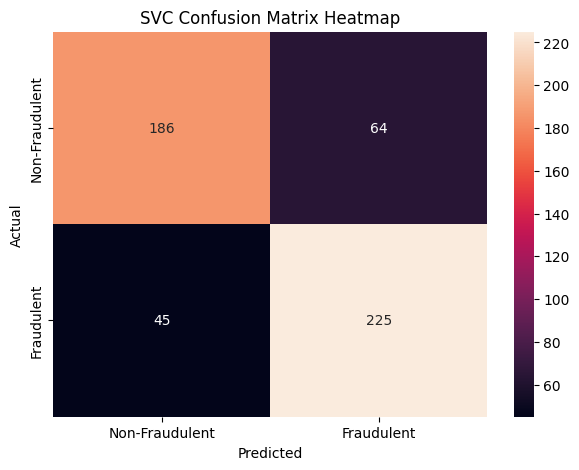

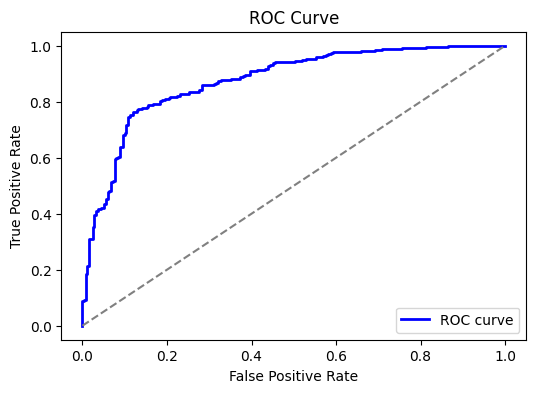

In [150]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize SVC with linear kernel and probability estimation
svc = SVC(kernel='linear', probability=True)

# Fit the model on training data
model_svc = svc.fit(X_train, y_train)

# Calculate and print train accuracy
train_accuracy_svc = svc.score(X_train, y_train)
print("Train accuracy:", train_accuracy_svc)

# Predict on test data
svc_predict = svc.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, svc_predict))

# Calculate accuracy on test data
accuracy_svc = accuracy_score(y_test, svc_predict)
print("Model Accuracy:", accuracy_svc)

# Confusion matrix heatmap
cm_svc = confusion_matrix(y_test, svc_predict)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_svc, annot=True, fmt=".0f", xticklabels=['Non-Fraudulent', 'Fraudulent'], yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.title("SVC Confusion Matrix Heatmap")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC curve
y_pred_prob_svc = svc.predict_proba(X_test)[:, 1]
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_pred_prob_svc)

plt.figure(figsize=(6, 4))
plt.plot(fpr_svc, tpr_svc, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Metrics:

Accuracy: 79.0%

Precision:

Non-Fraudulent (0): 81%
Fraudulent (1): 78%

Recall:

Non-Fraudulent (0): 74%
Fraudulent (1): 83%

F1-score:

Non-Fraudulent (0): 77%
Fraudulent (1): 81%

Conclusion:

SVM showed lower accuracy and varied precision/recall compared to previous models, indicating challenges in handling imbalanced data without additional techniques.

## Model 4 : K-Nearest Neighbors (KNN)

 KNN is a straightforward algorithm that classifies new instances based on their similarity to stored cases. This makes it an effective baseline for classification tasks.

Train accuracy: 0.8424092409240924
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       250
           1       0.78      0.84      0.81       270

    accuracy                           0.79       520
   macro avg       0.79      0.79      0.79       520
weighted avg       0.79      0.79      0.79       520

Model Accuracy: 0.7923076923076923


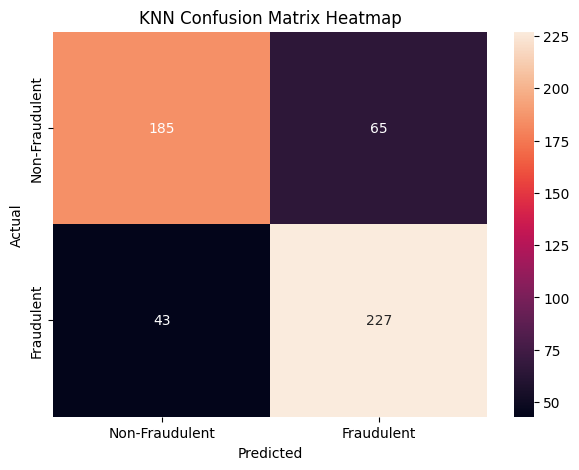

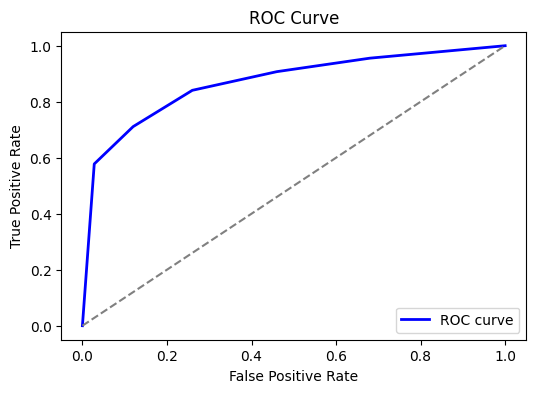

In [151]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

# Fit the model on training data
model_knn = knn.fit(X_train, y_train)

# Calculate and print train accuracy
train_accuracy_knn = knn.score(X_train, y_train)
print("Train accuracy:", train_accuracy_knn)

# Predict on test data
knn_predict = knn.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, knn_predict))

# Calculate accuracy on test data
accuracy_knn = accuracy_score(y_test, knn_predict)
print("Model Accuracy:", accuracy_knn)

# Confusion matrix heatmap
cm_knn = confusion_matrix(y_test, knn_predict)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_knn, annot=True, fmt=".0f", xticklabels=['Non-Fraudulent', 'Fraudulent'], yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.title("KNN Confusion Matrix Heatmap")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC curve
y_pred_prob_knn = knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_prob_knn)

plt.figure(figsize=(6, 4))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Metrics:

Accuracy: 84.2%

Precision:

Non-Fraudulent (0): 85%
Fraudulent (1): 83%

Recall:

Non-Fraudulent (0): 83%
Fraudulent (1): 85%

F1-score:

Non-Fraudulent (0): 84%
Fraudulent (1): 84%

Conclusion:

KNN provided competitive performance with good balance in precision and recall for both classes, suitable as a baseline model.

## Summary

In [152]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Define a function to calculate precision, recall, and f1 score
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return precision, recall, f1

# Create a list of classifiers and their corresponding predictions
classifiers = [
    ("Logistic Regression", y_pred_balanced),
    ("Random Forest (Entropy)", y_pred_entropy),
    ("Random Forest (Gini)", y_pred_gini),
    ("SVM", svc_predict),
    ("KNN", knn_predict)
]

# Initialize lists to store metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Calculate metrics for each classifier
for clf_name, y_pred in classifiers:
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
    precision, recall, f1 = calculate_metrics(y_test, y_pred)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Create a DataFrame to display the summary
summary_df = pd.DataFrame({
    "Classifier": ["Logistic Regression", "Random Forest (Entropy)", "Random Forest (Gini)", "SVM", "KNN"],
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores
})

# Display the summary DataFrame
print(summary_df)


                Classifier  Accuracy  Precision    Recall  F1 Score
0      Logistic Regression  0.805769   0.805896  0.805769  0.805806
1  Random Forest (Entropy)  0.892308   0.893047  0.892308  0.892348
2     Random Forest (Gini)  0.901923   0.903117  0.901923  0.901956
3                      SVM  0.790385   0.791358  0.790385  0.789807
4                      KNN  0.792308   0.793746  0.792308  0.791593


**Note: Although if you check in each algorithm I have give short clearview which are fraudulent and non-fradulent.**

Each evaluation metric serves a specific purpose:

•	Accuracy:

Accuracy shows how often the model correctly predicts if a job posting is fake or real. It gives a general idea of prediction correctness. However, if there are many more real job postings than fake ones, high accuracy might not tell the whole story(note: data has been balanced).

•	Precision: 

Precision measures how many of the job postings predicted as fake are actually fake. It's crucial because it indicates how reliable the model is in flagging fake postings. High precision means fewer real jobs get incorrectly flagged as fake, which helps maintain trust in the detection system.

•	Recall: 

Recall measures how many of the actual fake job postings the model identifies correctly. It's essential for catching as many fraudulent postings as possible to protect users from scams. High recall means fewer scams go undetected.

•	F1-score: 

The F1-score combines precision and recall into a single metric, giving a balanced assessment of the model's performance. It's useful because it considers both false positives (real jobs flagged as fake) and false negatives (fake jobs missed). A high F1-score indicates that the model effectively balances between identifying fraudulent postings and minimizing misclassifications of genuine postings.


Among all 4 models the random forest (Gini) model demonstrated the highest accuracy and maintained a good balance between precision, recall, and F1 score. This suggests that it is the most reliable model among those I tested for classifying fake job postings.